# Landing a Rover on Mars

In approaching this problem of modelling a rover's descent to Mars, we decided to take quite a general approach. That is to say, by merely changing several of the constants at the beginning of the program, many, very different, descent modules would be able to land successfully, via the optimisation of the opening of the parachute and the activation of the thrusters. The angles of entry can also be completely changed and given enough data, this program could effectively model the descent of a rover onto any planet. A major component of our model is the randomness we have incorporated throughout. Specifically, this is the variance that exists in all the constants we declare at the beginning as well as in the random wind. The random wind is calculated prior to the optimisation and so there is no real way to prepare for it. As such, every run through will differ substantially and we have no guarantee that a descent will succeed. However, this is exactly the same scenario faced by NASA and every other body trying to land a rover on Mars.

We recommend primarily changing the parameters in the 'Entry Parameters' section but the constants can also be changed.

We also decided to cover the transfer orbit and that is at the bottom of the program

### Work Distribution

As we have tackled this problem as a pair, we have had to distribute the workload.

Together:
- We did most of the maths together.
- We did a large portion of our debugging together.

Jonathan Ouwerx:
- Wrote the descent from the atmosphere to the surface in python and LaTex.

Louis Robson:
- Wrote the Hohmann Transfer from Earth to Mars in python and LaTex.



### Optimisation Process

The model follows a specific optimisation process in order to ensure the slowest impact speed possible. As such, the main 'start_descent' function is ran multiple times with different run types which are as follows:
- drag
- parachute
- thrusters
- main

#### Drag
The drag run type is primarily designed to support the parachute run type. It finds the maximum decceleration experienced by the descent module when it enters the atmosphere undergoing its first major decceleration. It finds the maximum of this decceleration so that if it is lower than the limit imposed by the brief of 100m/s2, the parachute run will still work. Specifically, it runs the descent without the use of any thrusters or a parachute, finding the max acceleration throughout the journey.

#### Parachute
The parachute run type finds the earliest possible time to open the parachute without exceeding the decceleration limit. It follows a several step process:
- record the current parameters
- open the parachute and iterate by one time period, recording the decceleration
- revert to the previous parameters ie when the parachute had not been opened
- iterate a time period without the parachute
By following this process, an acceleration curve is created and the decceleration as close to the acceleration limit, working from back to front is found. The time of this occurence is saved and used in the main run. To ensure that the rover is within a strong margin of safety, we have decreased the maximum acceleration from 100m/s2 to 90m/s2.

#### Thrusters
The thrusters run type finds the optimum altitude to release the parachute (detach it from the module) and activate the thrusters. It works as follows:
- Activate the thrusters at some starting height well above the optimum
- Iterate through the descent until the thrusters run out of fuel
- Calculate the height at which the thrusters ran out of fuel and multiply it by 0.7
- Deduct this height from the previous starting height and repeat.

This process is repeated until the descent module runs out of fuel within 0.1 m of the ground. The height is multiplied by 0.7 to ensure that the fuel consumption is never underestimated, which would add additional complexity to the optimisation. The altitude of the thruster activation is recorded and passed on to the main run.

#### Main
The main run incorporates the optimum parachute open time and thruster activation time and is the 'official' descent. It also incorporates the random wind, which means that every iteration is random and it is unknown what the final parameters will be. There is no way to ensure a successful landing, but our optimisation program and the safety of the airbag provide sufficient safeguards.

### Imports
These are the necessary modules for the simulation.
- math is used for any necessary trigonometry
- numpy is used for pi as well as the spherical plot
- matplotlib is used for all the graphs

In [1]:
from math import sin, cos, atan
import math
import numpy as np
from matplotlib import pyplot as plt

### Entry parameters

These are the main controllable parameters for the simulation. While other constants can be easily changed, these are the variables where customizability is the most reasonable and useful.

When it comes to changing the angles of entry, we recommend a combined angle of approximately 40 degrees, when evaluating polar and azimuth together. When you exceed 45 degrees, the first decceleration experienced by the module surpasses the acceleration limit. At that stage the rover makes no meaningful changes to its trajectory so is a hard cap imposed by the acceleration limit. We also do not recommend going below a combined angle of around 35 degrees as the descent module will merely miss the planet, reaching altitudes multiple times the radius of Mars before returning again. However the limits can be tested. Typically if a run-through exceeds 15-20 seconds, then the module has missed Mars.

In [2]:
# vertical angle of entry, changes
polar = 0
# horizontal angle of entry
azimuth = 40
# parachute area
p_area = 300
# fuel mass
fuel_mass = 50
# Time interval at which the parameters of the descent module are recorded
time_period = 0.01
# Calculates the variance as a percentage of the mean where the mean is the data taken from NASA
# The current value is excessive but depicts the effectiveness of the optimisation
variance_scale_factor = 0.01

### Normally Distributed Constants
These are the initial constants for the simulation and are categorized into Mars constants and rover constants.

While NASA has a substantial amount of data about Mars, we can't be sure that the data is 100% accurate. As such, we are going to find random values as modelled by a normal distribution for some of the least known Mars paramaters as well as rover parameters including angle of entry and velocity. The uncertainty for all the data can be changed above.

The data for the wind speed, altitude and variance is taking from an Colorado University Paper.

In [3]:
def RND(value):
    randomized = np.random.normal(value, value * variance_scale_factor)
    return randomized

m_c = {
    "rotation_time": RND(88_642),
    "radius" : RND(3_396_200),
    "polar_radius": RND(3_376_200),
    "mars_mass" : RND(6.39 * 10**23),
    "gravitational_constant" : 6.67408 * 10**(-11),
    "lapse_rate" : RND(0.0025),
    "molar_mass" : RND(0.0433),
    "gas_constant" : 8.3144598,
    "standard_density" : RND(0.020),
    "temp_ground_day" : RND(293.15),
    "temp_ground_night" : RND(210),
    "wind_variability" : RND(2),
    "wind_speed_data" : [1, 1, -1, -2, -2, -3, -4, -5, -5, -5, -4, -4, -1, 0,
                         6, 9, 14, 18, 19, 17, 12, 9, 8, 5, 5, 4, 4, 6],
    "wind_altitude_data" : [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 11000, 13000, 15000, 17000, 19000,
                            21000, 23000, 25000, 27000, 29000, 31000, 33000, 35000, 37000, 39000, 41000, 43000, 45000],
    "wind_variance_data" : [0.25, 0.25, 0.44, 2.8, 7.1, 3.4, 2.8, 2.8, 2.8, 2.8, 2.8, 9.0, 10.0, 10.0, 9.0, 13.0, 19.0,
                            17.0, 17.0, 25.0, 38.0, 36.0, 36.0, 38.0, 84.0, 160.0, 160.0, 44.0]
}
    
r_c = {
    "p_area" : p_area,
    "initial_fuel_mass" : fuel_mass ,
    "initial_polar" : RND(polar) *np.pi/180,
    "initial_azimuth": RND(azimuth) *np.pi/180,
    "initial_speed" : RND(4650),
    "initial_position" : [0, RND(m_c["radius"] + 1_500_000), 0],
    "base_mass" : 1100,
    "airbag_mass": 100,
    "shell_mass" : 200,
    "base_surface_area" : 35,
    "fuel_consumption_rate" : 2 * (10**-4),
    "max_thrust" : 6000,
    "airbag_SA" : 10,
    "airbag_pressure": 7000,
    "airbag_depth": 1,
    # This term must be defined manually as well as the depth and SA
    "airbag_volume": 10 * 1,
    "pressure_limit": RND(20_000_000) 
}

### Magnitude
Defines a function that can find the magnitude of any size vector.

In [4]:
def magnitude(vector):
    '''
    Parameters
    ----------
    vector : list
        some vector with two dimensions.

    Returns
    -------
    magnitude : int
        the magnitude of the vector.
    '''
    magnitude = 0
    for dimension in vector:
        magnitude += dimension ** 2
    magnitude = magnitude**0.5
    return magnitude

### Find Azimuth Angle
Finds the azimuth angle for a given vector. The azimuth angle is defined as the angle on the XY plane between the intial vector and the current vector. The following equation applies for the top right quadrant:

$\displaystyle \phi = \arctan(\frac{y}{x})$

In [5]:
def find_azimuth_angle(vector):
    '''
    Parameters
    ----------
    vector : list
        Vector of the module relative to static frame of reference
        centred on Mars.

    Returns
    -------
    angle : int
        Azimuth angle of the vector ranging from 0 to 2pi, where the positive y axis is 0
        and the angle increases clockwise.
    '''
    if vector[1] == 0:
        vector[1] = 0.00000000001
    if vector[0] == 0:
        vector[0] = 0.00000000001
    # Calculates the angle for each topographical quadrant
    if vector[1] >= 0:
        if vector[0] >= 0:
            angle = (atan(vector[0]/vector[1])) # Top right
        else:
            angle = (atan(vector[1]/-vector[0])+np.pi*3/2) # Top left

    else:
        if vector[0] >= 0:
            angle = (atan(-vector[1]/vector[0])+np.pi/2) # Bottom right
        else:
            angle = (atan(vector[0]/vector[1])+np.pi) #Bottom left
    return angle

### Find Polar Angle
Finds the polar angle for a given vector. The polar angle is defined as the angle caused by vertical displacement. The following equation applies for the top right quadrant:

$\displaystyle \theta = \arctan\bigg(\frac{z}{\sqrt{x^{2} + y^{2}}}\bigg)$

In [6]:
def find_polar_angle(vector):
    '''
    
    Parameters
    ----------
    vector : list
        Vector of the module relative to static frame of reference
        centred on Mars.

    Returns
    -------
    angle : int
        Polar angle of the vector ranging from pi/2 to -pi/2.
    '''
    height = vector[2]
    base = magnitude([vector[0],vector[1]])
    if base == 0:
        base = 0.00000001
    if height == 0 :
        angle = 0
    else:
        angle = atan(height/base)       
    return angle


### Change Basis to Perpendicular / Parrallel

Changes the basis of the velocity from the standard XY basis to the 'perpendicular/parrallel to the surface' basis.
In the new basis;
- $\vec{b_{1}}$ refers to motion parralel to the surface, where clockwise is positive, can be viewed as motion along parrallel concentric circles around Mars.
- $\vec{b_{2}}$ refers to motion towards and away from Mars, through the equator, where outwards is positive
- $\vec{b_{3}}$ refers to height, exactly the same as $\vec{z}$

The following calculation mutliplies the XY vector by a 3 dimensional rotation matrix that rotates the input vector by $\phi$ radians clockwise with $\mathbf{\hat{z}}$ as the rotation axis.

$\displaystyle M_{XY\rightarrow B} \left[\begin{matrix}x\\y\\z\end{matrix}\right]
= \left[\begin{matrix}
  \cos(\phi) & \sin(\phi) & 0 \\
  -\sin(\phi) & \cos(\phi) & 0 \\
  0 & 0 & 1\end{matrix}\right]
  \left[\begin{matrix}x\\y\\z\end{matrix}\right]
 = \left[\begin{matrix}b_{1}\\b_{2}\\b_{3}\end{matrix}\right]$
 
 A vector-matrix multiplication is performed to achieve the new basis.


In [7]:
def convert_from_xy_to_b(velocity, position):
    '''
    Parameters
    ----------
    velocity : list
        Vector velocity of the descent module in the standard basis. 
    position : list
        Position of the module relative to static frame of reference centred on Mars.

    Returns
    -------
    converted_from_xy : list
        Vector velocity of the descent module with perpendicular / parralel basis.
    '''
    # rotates the velocity vector around the z axis
    angle = find_azimuth_angle(position)

    matrix = [[cos(angle), -sin(angle), 0],
              [sin(angle), cos(angle), 0],
              [0         , 0         , 1]]

    x,y,z = velocity[0], velocity[1], velocity[2]

    converted_from_xy = [x*matrix[0][0] +y*matrix[0][1] +z*matrix[0][2],
                         x*matrix[1][0] +y*matrix[1][1] +z*matrix[1][2],
                         x*matrix[2][0] +y*matrix[2][1] +z*matrix[2][2]]

    return converted_from_xy

### Change Basis from Perpendicular / Parrallel

Changes the basis of the velocity from the 'perpendicular/parrallel to the surface' basis to the standard XY basis.

The following matrix is a 3 dimensional rotation matrix that rotates by $\phi$ radians anticlockwise with $\mathbf{\hat{z}}$ as the rotation axis.

The following calculation mutliplies the XY vector by a 3 dimensional rotation matrix that rotates the input vector by $\phi$ radians clockwise with $\mathbf{\hat{z}}$ as the rotation axis.

$\displaystyle M_{B\rightarrow XY} \left[\begin{matrix}b_{1}\\b_{2}\\b_{3}\end{matrix}\right]
= \left[\begin{matrix}
  \cos(\phi) & \sin(\phi) & 0 \\
  -\sin(\phi) & \cos(\phi) & 0 \\
  0 & 0 & 1\end{matrix}\right]
  \left[\begin{matrix}b_{1}\\b_{2}\\b_{3}\end{matrix}\right]
 = \left[\begin{matrix}x\\y\\z\end{matrix}\right]$
 
 A vector-matrix multiplication is performed to achieve the new basis.

In [8]:
def convert_from_b_to_xy(velocity, position):
    '''
    Parameters
    ----------
    velocity : list
        Vector velocity of the descent module in the perpendicular/parrallel basis.
    position : list
        Position of the module relative to static frame of reference
        centred on Mars.

    Returns
    -------
    converted_from_b : list
        Vector velocity of the descent module in the standard basis.
    '''

    angle = find_azimuth_angle(position)

    matrix = [[cos(angle), sin(angle), 0],
              [-sin(angle), cos(angle), 0],
              [0         , 0         , 1]]

    x,y,z = velocity[0], velocity[1], velocity[2]

    converted_from_b = [x*matrix[0][0] +y*matrix[0][1] +z*matrix[0][2],
                         x*matrix[1][0] +y*matrix[1][1] +z*matrix[1][2],
                         x*matrix[2][0] +y*matrix[2][1] +z*matrix[2][2]]

    return converted_from_b

### Find Radius

Finds the radius of Mars at a given z value, assuming a perfectly spheroid structure.

$ \displaystyle
\text{radius} = 
\sqrt{\frac
{  (r_{e}^{2} \cdot \cos{(L)})^{2} + (r_{p}^{2} \cdot \sin{(L)})^{2}  }
{  (r_{e} \cdot \cos{({L})})^{2} + (r_{p} \cdot \sin({L}))^{2}}  }$ 

$ \displaystyle
\\r_{e} : \text{equatorial radius}
\\r_{p} : \text{polar radius} 
\\L : \text{latitude}$


In [9]:
def radius(position):
    '''
    Parameters
    ----------
    position : list
        Position of the module relative to static frame of reference
            centred on Mars.
            
    Returns
    -------
    radius : int
        Radius of Mars at a given altitude.
    '''
    
    latitude = abs(find_polar_angle(position))
    radius = ( ( ((m_c["radius"])**2 * cos(latitude))**2 + ((m_c["polar_radius"])**2 *sin(latitude))**2 ) /
               ( ((m_c["radius"]) *cos(latitude))**2 + ((m_c["polar_radius"]) *sin(latitude))**2 )) ** 0.5

    return radius

### Find Atmospheric Velocity

The function first finds the circumference of the sphere at a given z value. The atmosphere acting on the rover is only dependant on the z value as it acts in circular planes.

$\displaystyle \text{Circumference} = 2\pi\sqrt{2\text{R}\text{h} - \text{h}^{2}}$ 

The circumference and the sidereal rotation period are used to calculate the atmosphere velocity in the parrallel / perpendicular basis. 

$\displaystyle \text{speed} = \frac{\text{circumference}}{\text{time period}}$

Finally, the atmosphere velocity is converted to the standard basis using the conversion function above.

However, if the module is beyond either of the poles, the function automatically returns an atmosphere velocity of 0.

It has also been assumed that the velocity of the atmopshere at all points on a given plane remains at the same velocity as at the surface of the planet. Experimental data shows that this is largely the case except for extremely high altitudes. At least on Earth, once an altitude of 200km is reached, the atmosphere rotates at a slightly faster velocity. However, this can be ignored as the atmospheric density at such an altitude is so small as to have a negligible impact on the trajectory of the descent module.

In [10]:
def find_atmosphere_velocity(position):
    '''
    Parameters
    ----------
    position : list
        Position of the module relative to static frame of reference
            centred on Mars.
            
    Returns
    -------
    atmosphere_velocity : list
        Velocity of Mars' atmosphere as experienced by a completely stationary observer on the surface.
    '''
    
    if abs(position[2]) < m_c["polar_radius"]:
        height = m_c["polar_radius"] - position[2]
        circumference = 2*np.pi*(2*radius(position)*height-height**2)**0.5
        atmosphere_speed = [-circumference / m_c["rotation_time"], 0, 0]
        atmosphere_velocity = convert_from_b_to_xy(atmosphere_speed, position)
    else:
        atmosphere_velocity = [0,0,0]
    return atmosphere_velocity

### Wind Interpolation
The available data for wind is as expected in discrete form. As such, this function linearly interpolates the expected speed for altitudes between the datapoints given in the data. For a given altitude input, it finds the wind speeds of the lower and upper altitude datapoints  which shall be called $v_{L}$ and $v_{U}$ respectively. The upper and lower altitudes are labelled $A_{L}$ and $A_{U}$ respectively and the input altitude and output velocity are $A$ and $v$.

$\displaystyle v = v_{L} + (v_{U}-v_{L}) \cdot \frac{A - A_{L}} {A_{U} - A_{L}} $



In [11]:
def wind_interpolation(altitude, altitude_data, wind_data):
    '''
    Parameters
    ----------
    altitude : int
        Altitude of the descent module over the surface of Mars.
    altitude_data: int
        List of altitudes taken from research paper.
    wind_data: int
        List of wind speeds taken from research paper.
            
    Returns
    -------
    approximate_wind : int
        The interpolated wind speed at any given altitude.
    '''
    for i in range(len(altitude_data)):
        if altitude_data[i] > altitude:
            upper_value, upper_index = altitude_data[i], i
            lower_value, lower_index = altitude_data[i-1], i-1
            break
    
    approximate_wind = wind_data[i-1] + (wind_data[i] - wind_data[i-1]) * ((altitude - altitude_data[i-1])/(altitude_data[i]-altitude_data[i-1]))
    return approximate_wind

### Find Wind Velocity
Research into wind velocity on Mars yielded the data given in the constants dictionary. The wind on Mars can be summarized as either being north or south with a certain mean speed and variance. Using this data and the interpolation function described above, wind speeds can be calculated. At any one time, there is a wind speed and a wind speed target, with the wind speed being able to change at a predetermined rate. Initially the wind speed is 0 and the target is 0. When the rover passes 50km, a normal distribution using the data in the dictionary is created and a output is taken. This is the target velocity. Every iteration, the wind speed approaches the target wind speed within the bounds of the wind max acceleration. As soon as the target velocity is attained, a new target is obtained from a normal distribution using the new altitude. This process repeats until the end of the simulation.

Finally, the wind speed from north to south, at any latitude, is converted into the standard basis through a series of calculations.

In [12]:
def find_wind_velocity(position, wind_speed, target, time_period):
    '''
    Parameters
    ----------
    position : list
        Position of the module relative to static frame of reference
        centred on Mars.
    wind_speed: int
        Current speed of the wind.
    target: int
        Target speed of the wind.
    time_period : int
        Interval between each parameter update.
            
    Returns
    -------
    wind_speed: int
        Current speed of the wind.
    wind_velocity: list
        Current velocity of the wind.
    target: int
        Target speed of the wind.
    '''
    altitude = magnitude(position) - radius(position) 
    if (abs(target - wind_speed) < 1):
        mean_speed = wind_interpolation(altitude, m_c["wind_altitude_data"], m_c["wind_speed_data"])
        variance = wind_interpolation(altitude, m_c["wind_altitude_data"], m_c["wind_variance_data"])
        target = np.random.normal(mean_speed, variance)
    elif target < wind_speed:
        wind_speed -= time_period * m_c["wind_variability"]
    else:
        wind_speed += time_period * m_c["wind_variability"]
    polar = find_polar_angle(position)
    b_wind_velocity = [0,wind_speed*sin(polar), wind_speed*cos(polar)]
    wind_velocity = convert_from_b_to_xy(b_wind_velocity, position)
    return wind_speed, wind_velocity, target

### Status Update

Prints the current parameters of the module.

In [13]:
def status_update(time, position, density, drag, g_force, acceleration, velocity, relative_velocity,
                  atmosphere_velocity, current_mass, fuel_mass, thrust, max_pressure):
    
    print("")
    print(time,"seconds:")
    print("position:",position,"m")
    #print("density:",density,"kg/m3")
    print("fuel mass:", fuel_mass, "kg")
    print("total mass:", current_mass, "kg")
    print("thrust:", thrust, "N")
    print("drag:",drag,"N")
    print("g_force:",g_force,"N")
    print("acceleration:",acceleration,"m/s2")
    print("acceleration magnitude:",(magnitude(acceleration)),"m/s2")
    print("atmosphere_velocity", atmosphere_velocity)
    print("relative_velocity",relative_velocity)
    print("velocity:",velocity,"m/s")
    print("speed", magnitude(velocity), "m/s")
    print("max_pressure", max_pressure)
    print("relative speed", magnitude(relative_velocity))

### Find Gravity

Calculates the instantaneous gravitational force experienced by the module 

$\displaystyle \text{gravitational force} = \frac{G \cdot M \cdot m}{r^{2}}$

The gravitational scalar force is then resolved in the parrallel/perpendicular basis with trigonometry.

$\displaystyle \vec{F}_{g} = \left[
 \begin{matrix}
  0 \\
  F_{g} \cdot \cos{\theta}\\
  F_{g} \cdot \sin{\theta}
 \end{matrix}
\right]$ 

The $\vec{b_{1}}$ component will always be zero as there is no component of gravity that is not towards the centre of Mars.

Finally, the vector is converted to the standard basis.

In [14]:
def find_gravity(position, current_mass):
    '''
    Parameters
    ----------
    position : list
        Position of the module relative to static frame of reference
        centred on Mars.
    current_mass : int
        Momentary mass of the module, accounting for discarded parts and fuel.

    Returns
    -------
    xy_gravity : int
        Vector force experienced by the module in the standard basis.

    '''

    polar = find_polar_angle(position)
    azimuth = find_azimuth_angle(position)
    g_force = ((m_c["gravitational_constant"] * (m_c["mars_mass"]) * current_mass)
                /(magnitude(position))**2)

    b_gravity = [0, 
                 -g_force * cos(polar),
                 -g_force * sin(polar)]
    
    xy_gravity = convert_from_b_to_xy(b_gravity, position)

    return xy_gravity

### Find Atmospheric Density

Calculates the atmospheric density using the Barometric Formula with a non-zero lapse rate. First, the gravitational acceleration on Mars is calculated.

$\displaystyle \text{gravitational acceleration} = \frac{G \cdot M}{r^{2}}$

Then the barometric formula is used to calculate the density as a function of position and temperature.

$\displaystyle {\rho }=\rho _{o}\cdot \left[{\frac {T_{o}}{T_{o}+L\cdot (A)}}\right]^{\left(1+{\frac {g_{o}\cdot M}{U\cdot L}}\right)}$

- $\rho$ : density
- $\rho_{o}$ : standard density
- $T_{o}$ : standard temperature
- $A$ : altitude
- $g_{o}$ : gravitational acceleration
- $L$ : lapse rate

In [15]:
def find_atmospheric_density(position, temp_ground):
    '''     
    Parameters
    ----------
    position : list
        Position of the module relative to static frame of reference
        centred on Mars.
    temp_ground : int
        Standard temperature of Mars surface, on the equator,
        in the summer, either during the day or the night.

    Returns
    -------
    density : int
        Density of the atmosphere at the given altitude.

    '''
    g_acceleration = (m_c["gravitational_constant"]*(m_c["mars_mass"])/
                      ((magnitude(position))**2))

    # Barometric Formula
    density = (m_c["standard_density"] * 
                  (temp_ground / (temp_ground + m_c["lapse_rate"] * (magnitude(position) - radius(position)))) ** 
                  (1 + ((g_acceleration * m_c["molar_mass"])/(m_c["gas_constant"] * m_c["lapse_rate"]))))
    return density

### Find Drag

This process calculates the drag force experienced by the descent module and the parachute.

The velocity of the descent module is calculated relative to the rotating atmosphere on the same latitudinal plane. The relative velocity is found by subtracting the atmosphere velocity from the actual velocity.

Drag is found by component using the drag equation.

$\displaystyle \text{Drag} = \frac{1}{2} \cdot \rho \cdot A \cdot C_{D} \cdot v^{2} $

- $\rho$ : atmospheric density
- A : cross sectional area
- $C_{D}$ : drag coefficient
- v : relative velocity

As the velocity is squared in the equation, its direction is lost, so it has to be adjusted at the end to reflect the appropriate direction.

In [16]:
def find_drag(density, surface_area, velocity, position, wind_velocity):
    '''
    Calculates the drag force experienced by the descent module and the parachute

    Parameters
    ----------
    density : int
        Density of the atmosphere at the given altitude.
    surface_area : int
        Total surface area of the module and parachute (if open).
    velocity : list
        Vector velocity of the descent module in the standard basis.
    position : list
        Position of the module relative to static frame of reference
        centred on Mars.
    wind_velocity: list
        Current velocity of the wind.

    Returns
    -------
    drag : list
        Vector drag force experienced by the module in the standard basis.

    '''

    atmosphere_velocity = find_atmosphere_velocity(position)
    # Velocity of the module relative to the rotating atmosphere
    relative_velocity = [velocity[0] - atmosphere_velocity[0] - wind_velocity[0],
                         velocity[1] - atmosphere_velocity[1] - wind_velocity[1],
                         velocity[2] - atmosphere_velocity[2] - wind_velocity[2]]
    # aerodynamic coefficient
    k = 1
    # Drag equation
    h_drag = 0.5 * k * density * surface_area * relative_velocity[0]**2
    v_drag = 0.5 * k * density * surface_area * relative_velocity[1]**2
    z_drag = 0.5 * k * density * surface_area * relative_velocity[2]**2
    #  if  horizontal velocity is positive/'left', drag wil negative/'right'
    if relative_velocity[0] >= 0:
        h_drag = -h_drag
    #  if  vertical velocity is positive/'up', drag wil be negative/'down'
    if relative_velocity[1] >= 0:
        v_drag = -v_drag
    if relative_velocity[2] >= 0:
        z_drag = -z_drag
    drag = [h_drag, v_drag, z_drag]
    return drag

### Find Thrust 

The thrust will be assumed to be always acting opposite to the direction of motion. This assumption is made on the expectation of some form of intelligent thruster-use as well as some variability in thruster direction in any real Mars descent.

Thrust needs to be calculated with respect to relative velocity, otherwise the thrusters would not work to stop the descent module relative to the surface, but rather at a speed differing by 240m/s, the atmospheric velocity. It is found as follows:

$\displaystyle F_{x} = -F_{max} \cdot \frac{v_{x}}{|v|}, \quad$
$\displaystyle F_{y} = -F_{max} \cdot \frac{v_{y}}{|v|}, \quad$
$\displaystyle F_{z} = -F_{max} \cdot \frac{v_{z}}{|v|}$

The current fuel mass is also calculated in this function:

$\displaystyle \text{Fuel Mass} = m_{f} - \left( \Delta t \cdot c_{f} \cdot F_{max} \right)$ 

- $m_{f} $ : previous fuel mass
- $\Delta t $ : time period for each iteration
- $c_{f} $ : fuel consumption rate
- $F_{max}$ : max thrust

However, if the thrusters boolean is set to False, a thrust force of zero is returned.

In [17]:
def find_thrust(thrusters_on, velocity, fuel_mass, time_period, position, wind_velocity):
    '''       

    Parameters
    ----------
    thrusters_on : boolean
        True if thrusters on, False if thrusters off.
    velocity : list
        Vector velocity of the descent module in the standard basis.
    fuel_mass : int
        Mass of remaing fuel.
    time_period : int
        Interval between each parameter update.
    position : list
        Position of the module relative to static frame of reference
        centred on Mars.
    wind_velocity: list
        Current velocity of the wind.

    Returns
    -------
    thrust : list
        Vector thrust force experienced by the module.
    fuel_mass : int
        Mass of remaing fuel.

    '''

    # Thrust works against velocity relative to atmosphere not pure velocity
    atmosphere_velocity = find_atmosphere_velocity(position)
    # Velocity of the module relative to the rotating atmosphere
    relative_velocity = [velocity[0] - atmosphere_velocity[0] - wind_velocity[0],
                         velocity[1] - atmosphere_velocity[1] - wind_velocity[1],
                         velocity[2] - atmosphere_velocity[2] - wind_velocity[2]]

    if thrusters_on == True:
        # Uses trig to resolve thrust
        max_thrust = r_c["max_thrust"]
        x_thrust = -max_thrust * relative_velocity[0]/magnitude(relative_velocity)
        y_thrust = -max_thrust * relative_velocity[1]/magnitude(relative_velocity)
        z_thrust = -max_thrust * relative_velocity[2]/magnitude(relative_velocity)

        # Calculates fuel burn
        fuel_mass -= (time_period * r_c["fuel_consumption_rate"] * r_c["max_thrust"])
        thrust = [x_thrust, y_thrust, z_thrust]
    else:
        thrust = [0,0,0]
    return thrust, fuel_mass

### Find Airbag Force 

This function finds the upward force that the airbag exerts on the descent module. The entire function is governed by a conditional statement that implements a non-zero force if the rover is within a metre of the ground and the airbag has not yet popped.

Then the velocity towards to the ground is calculated and the compression of the airbag as well, given the time period. The new pressure is calculated using Boyle's Law and consequently the force is found:

$\displaystyle P = \frac{P_{0} V_{0}}{V} \quad F = \frac{P}{A}$

This force is then converted into the standard basis through a series of calculations. A conditional statement records the maximum pressure experienced.

In [18]:
def find_airbag_force(position, current_mass, velocity, airbag_depth, time_period, max_pressure, airbag_contact):
    '''
    Parameters
    ----------
    position : list
        Position of the module relative to static frame of reference
        centred on Mars.
    current_mass : int
        Momentary mass of the module, accounting for discarded parts and fuel.
    velocity : list
        Vector velocity of the descent module in the standard basis.
    airbag_depth : int
        The initial depth/height of the airbag minus the total compression.
    time_period : int
        Interval between each parameter update.
    max_pressure : int
        The maximum pressure as of yet experienced by the airbag.
    airbag_contact : boolean
        A boolean referring to whether the airbag has made contact with the ground.
        
    
    Returns
    -------
    force: list
        The XY vector force the airbag exerts on the descent module.
    airbag_depth : int
        The initial depth/height of the airbag minus the total compression. 
    airbag_contact : boolean
        A boolean referring to whether the airbag has made contact with the ground.
    max_pressure : int
        The maximum pressure as of yet experienced by the airbag.
    contact_velocity: 
        The XY vector velocity of the airbag as it makes contact with the ground.
    time_period : int
        Interval between each parameter update.
    
    '''
    if ((magnitude(position) - radius(position)) <= 1) and (max_pressure < r_c["pressure_limit"]):
        atmosphere_velocity = find_atmosphere_velocity(position)
        relative_velocity = [velocity[0] - atmosphere_velocity[0],
                             velocity[1] - atmosphere_velocity[1],
                             velocity[2] - atmosphere_velocity[2]]
        if airbag_contact == False:
            contact_velocity = magnitude(relative_velocity)
        elif airbag_contact == True:
            contact_velocity = 0
        airbag_contact = True
        b_velocity = convert_from_xy_to_b(relative_velocity, position)
        compression = magnitude([b_velocity[1], b_velocity[2]]) * time_period
        volume = (airbag_depth + compression) * r_c["airbag_SA"]
        airbag_depth += compression
        pressure = (r_c["airbag_pressure"] * r_c["airbag_volume"]) / volume
        scalar_force = pressure * r_c["airbag_SA"]
        polar = find_polar_angle(position)
        b_force = [0, scalar_force*cos(polar), scalar_force*sin(polar)]
        force = convert_from_b_to_xy(b_force, position)
        if pressure > max_pressure:
            max_pressure = pressure
    else: 
        force = [0,0,0]
        airbag_contact = False
        contact_velocity = 0
    return force, airbag_depth, airbag_contact, max_pressure, contact_velocity, time_period

### Find Position 

Calculates the position of the module relative to its stationary frame of reference centred on Mars.

In [19]:
def find_position(position, velocity, time_period):
    '''
    Parameters
    ----------
    position : list
        Position of the module relative to static frame of reference
        centred on Mars.
    velocity : list
        Vector velocity of the descent module in the standard basis.
    time_period : int
        Interval between each parameter update.

    Returns
    -------
    position : list
        Position of the module relative to static frame of reference
        centred on Mars.
    '''

    x_position = position[0] + velocity[0] * time_period
    y_position = position[1] + velocity[1] * time_period
    z_position = position[2] + velocity[2] * time_period

    position = [x_position, y_position, z_position]

    return position

### Get Acceleration
Combines the different forces and the mass of the descent module to calculate the vector acceleration of the descent module.

In [20]:
def get_acceleration_from_forces(current_mass, g_force, drag, thrust, airbag_force):
    '''
  

    Parameters
    ----------
    current_mass : int
        Momentary mass of the module, accounting for discarded parts and fuel.
    g_force : int
        Vector force experienced by the module in the parallel/perpendicular
        the surface basis.
    drag : list
        Vector drag force experienced by the module in the standard basis.
        by the descent module.
    thrust : list
        Vector thrust force experienced by the module.
    airbag_force: list
        The XY vector force the airbag exerts on the descent module.

    Returns
    -------
    acceleration : list
        Vector acceleration of the descent module in the standard basis.

    '''

    x_acc = (g_force[0] + drag[0] + thrust[0] + airbag_force[0])/current_mass
    y_acc = (g_force[1] + drag[1] + thrust[1] + airbag_force[1])/current_mass
    z_acc = (g_force[2] + drag[2] + thrust[2] + airbag_force[2])/current_mass
    acceleration = [x_acc, y_acc, z_acc]
    return acceleration

### Find Velocity 
Finds the vector velocity of the descent module relative to the atmosphere in the module's current position.


In [21]:
def find_velocity(velocity, acceleration, time_period, position):
    '''
    Parameters
    ----------
    velocity : list
        Vector velocity of the descent module in the standard basis.
    acceleration : list
        Vector acceleration of the descent module in the standard basis.
    time_period : int
        Interval between each parameter update.
    position : list
        Position of the module relative to static frame of reference
        centred on Mars.

    Returns
    -------
    velocity : list
        Vector velocity of the descent module in the standard basis.
    relative_velocity : list
        Velocity of the descent module in the standard basis relative to the rotating atmosphere.
    atmosphere_velocity : list
        Velocity of Mars' atmosphere as experienced by a completely stationary observer on the surface.

    '''
    atmosphere_velocity = find_atmosphere_velocity(position)
    relative_velocity = [velocity[0] - atmosphere_velocity[0],
                         velocity[1] - atmosphere_velocity[1],
                         velocity[2] - atmosphere_velocity[2]]

    x_vel = velocity[0] + acceleration[0] * time_period
    y_vel = velocity[1] + acceleration[1] * time_period
    z_vel = velocity[2] + acceleration[2] * time_period
    velocity = [x_vel, y_vel, z_vel]

    return velocity, relative_velocity, atmosphere_velocity

### Sun Check  

Checks whether the module is in the sun, returning the relevant temperature.

Returns the night time temperature if the descent module is on the other side of Mars from the sun and if it is within parralel lines running from the sun to Mars. We have assumed these lines to be parralel due to the enormous distance between Mars and the Sun.

In [22]:
def sun_check(position):
    '''

    Parameters
    ----------
    position : list
        Position of the module relative to static frame of reference
        centred on Mars.

    Returns
    -------
    temp_ground : int
        Standard temperature of Mars surface, on the equator,
        in the summer, either during the day or the night.

    '''
    if (position[1] < 0) and magnitude([position[0], position[2]]) < m_c["radius"]:
        return m_c["temp_ground_night"]
    else:
        return m_c["temp_ground_day"]

### Determine Stage 

Determines whether the module is in freefall, has opened its parachute or has released its parachute. It has separate logic for each run type.

The descent module has three possible stages:
- The descent module is in freefall.
- The parachute has been 'opened', greatly slowing the descent module down.
- The parachute has been 'released' (the parachute is no longer attached)

There are also several different variations of the determine stage function dependant on the run type. The drag run type ensures the thrusters are not activated and the parachute is never released. The parachute run type opens the parachute if it is a parachute testing iteration and keeps it closed if it is a pass through iteration. The same logic is used for the thrusters and main run with two exceptions. 
- The thrusters run has a 'first_release' variable that is true if the thrusters are being activated for the first time. With this knowledge, a 'screenshot' of the previous state can be recorded so the simulation can revert to it at a later stage.
- The main run type records the moment of thruster activation for graphical representation at a later stage.
There are two main conditional statements. First, the function checks if the current time has exceeded the optimum time, at which point the parachute as openend. Second, given that the parachute has been opened, if the current altitude is below the optimum altitude threshold, the parachute is released and the thrusters are activated.

In [23]:
def determine_stage(velocity, position, time, open_time, release_threshold_alt, run_type, test_parachute, thrusters_on, release_time, p_released, fuel_mass):
    '''
    Parameters
    ----------
    velocity : list
        Vector velocity of the descent module in the standard basis.
    position : list
        Position of the module relative to static frame of reference
        centred on Mars.
    time : int
        Time that has passed from the initial state.
    open_time : int
        Time that the parachute should be opened.
    release_threshold_alt : int
        Altitude that the parachute should be released/disattached
        and the thrusters activated.
    run_type : string
        Designates the descent as either the main run or 
        one of the optimisation runs.
    test_parachute : boolean
        Relevant to the parachute run. Determines whether to open parachute.
    thrusters_on : boolean
        True if thrusters on, False if thrusters off.
    release_time : int
        Records the time that the parachute was released.
    p_released : boolean
        Records whether the parachute has been released.
    fuel_mass : int
        Mass of remaing fuel.

    Returns
    -------
    test_parachute : boolean
        Relevant to the parachute run. Determines whether to open parachute.
    p_open : boolean
        Records whether the parachute has been opened.
    p_released : boolean
        Records whether the parachute has been released.
    thrusters_on : boolean
        True if thrusters on, False if thrusters off.
    release_time : int
        Records the time that the parachute was released.
    first_release : boolean
        Records whether parachute has just been released.

    '''

    # For the drag max acceleration calculation
    # Doesn't require the parachute or thrusters at all
    if run_type == 'drag':
        p_open = False
        p_released = False
        first_release = False

    # For the parachute optimisation run
    # If testing parachute, opens it and switches boolean to false
    # If non parachute iteration, keeps it closed and switches boolean to true
    elif run_type == 'parachute':
        p_released = False
        first_release = False
        if test_parachute == True:
            p_open = True
            test_parachute = False
        else: 
            test_parachute = True
            p_open = False
    
    else:
        if run_type == 'main':
            first_release = False
        # Checks if module has passed parachute open threshold
        if time > open_time:
            p_open = True
            # Checks if module has passed parachute release threshold
            if (magnitude(position) - radius(position)) < release_threshold_alt:
                # Records whether the parachute has been released this iteration 
                if p_released == False:
                    if run_type == 'main':
                        release_time = time
                    elif run_type == 'thrusters':
                        first_release = True
                else:
                    if run_type == 'thrusters':
                        first_release = False 
                p_released = True
                # finds velocity perpendicular to the surface    
                b_velocity = convert_from_xy_to_b(velocity, position)
                #turns on/maintains thrusters if there is fuel remaining and is not going upwards
                if (fuel_mass > 0) and (b_velocity[1] < 0):
                    thrusters_on = True  
                else: 
                    thrusters_on = False
            else:
                p_released = False
                if run_type == 'thrusters':
                    first_release = False
        else:
            p_open = False
            p_released = False
            if run_type == 'thrusters':
                first_release = False
            
    return test_parachute, p_open, p_released, thrusters_on, release_time, first_release


### Determine Mass 
This function determines the mass of the descent module at any given time. It has been assumed that as soon as the thrusters are activated, the heatshell is discarded and the parachute is detached. As such, we simply have two equations; one for before the thrustera activation and one for after.

In [24]:
def determine_mass(fuel_mass, p_mass, p_open, p_released):
    '''
    Determines the mass of the module, dependant on the current stage
    of the module and the fuel used.

    Parameters
    ----------
    fuel_mass : int
        Mass of remaing fuel.
    p_mass : int
        Mass of the parachute.
    p_open : boolean
        Records whether the parachute has been opened.
    p_released : boolean
        Records whether the parachute has been released.

    Returns
    -------
    current_mass : int
        Momentary mass of the module, accounting for discarded parts and fuel.

    '''
    if p_released == False:
        current_mass = r_c["base_mass"] + r_c["airbag_mass"] + r_c["shell_mass"] + fuel_mass  + p_mass
    else:
        current_mass = r_c["base_mass"] + r_c["airbag_mass"] + fuel_mass
    return current_mass

### Determine Surface Area 
This function finds the current surface area of the descent module. Using booleans set in the determine stage function, the function checks if the parachate has not been opened or whether it has been released and increases the effective surface area accordingly.

In [25]:
def determine_surface_area(p_open, p_released):
    '''
    Determins the surface area of the module dependant on the stage.

    Parameters
    ----------
    p_open : boolean
        Records whether the parachute has been opened.
    p_released : boolean
        Records whether the parachute has been released.

    Returns
    -------
    current_surface_area : int
        Momentary surface area of the module ie with/out parachute.

    '''
    if (p_open == False) or (p_released == True):
        current_surface_area = r_c["base_surface_area"]
    else:
        current_surface_area = r_c["p_area"] + r_c["base_surface_area"]
    return current_surface_area

### Plot Altitude 
Plots the altitude of the rover in kilometres on the y axis and time in seconds on the x axis.

In [26]:
def plot_altitude(time_data_seconds, altitude_data_km):
    '''
    Parameters
    ----------
    time_data_seconds : list
        Time index list.
    altitude_data_km : list
        Altitude(km) of the module in each time period.

    Returns
    -------
    None.

    '''
    plt.plot(time_data_seconds,altitude_data_km)
    plt.margins(x=0, y=0)
    plt.title("Altitude of the Descent Module")
    plt.ylabel("Altitude(km)")
    plt.xlabel("Time(seconds)")
    plt.show()


### Plot Velocity 
Plots the velocity of the rover in metres per second on the y axis and time in seconds on the x axis. There are three displayed lines;
- Velocity magnitude
- Velocity in the $\vec{x}$ component
- Velocity in the $\vec{y}$ component
- Velocity in the $\vec{z}$ component
The graph also displays the open and release time of the descent module.

In [27]:
def plot_velocity(time_data_seconds, velocity_data, release_time, open_time):
    '''
    Parameters
    ----------
    time_data_seconds : list
        Time index list.
    velocity_data : list
        Velocity of the module in each time period.
    release_time : int
        Records the time that the parachute was released.
    open_time : int
        Time that the parachute should be opened.

    Returns
    -------
    None.

    '''
    velocity_data_x = []
    velocity_data_y = [] 
    velocity_data_z = [] 
    velocity_data_mag = []
    for i in velocity_data:
        velocity_data_x.append(i[0])
        velocity_data_y.append(i[1])
        velocity_data_z.append(i[2])
        velocity_data_mag.append(magnitude(i))
    plt.title("Velocity of the Descent Module")
    plt.ylabel("Velocity(m/s)")
    plt.xlabel("Time(seconds)") 
    plt.margins(x=0)
    plt.plot(time_data_seconds,velocity_data_mag, label='Magnitude')
    plt.plot(time_data_seconds,velocity_data_x, label='X')
    plt.plot(time_data_seconds,velocity_data_y, label='Y')
    plt.plot(time_data_seconds,velocity_data_z, label='Z')
    plt.axvline(x=release_time, color='red', linestyle='dashed', linewidth=1.5, alpha = 0.3, label = 'Release')
    plt.axvline(x=open_time, color='purple', linestyle='dashed', linewidth=1.5, alpha = 0.3, label = 'Open') 
    plt.margins(x=0)
    plt.legend(loc = 'upper right')
    plt.show()

### Plot Acceleration 
Plots the acceleration of the rover in metres per second on the y axis and time in seconds on the x axis. There are three displayed lines;
- Acceleration magnitude
- Acceleration in the $\vec{x}$ component
- Acceleration in the $\vec{y}$ component
- Acceleration in the $\vec{z}$ component
The graph also displays the open and release time of the descent module.

In [28]:
def plot_acceleration(time_data_seconds, acceleration_data, release_time, open_time):
    '''
    Parameters
    ----------
    time_data_seconds : list
        Time index list.
    acceleration_data : list
        Acceleration of the module in each time period.
    release_time : int
        Records the time that the parachute was released.
    open_time : int
        Time that the parachute should be opened.

    Returns
    -------
    None.

    '''
    acceleration_data_x = []
    acceleration_data_y = []
    acceleration_data_z = []
    acceleration_data_mag = []
    for i in acceleration_data:
        acceleration_data_x.append(i[0])
        acceleration_data_y.append(i[1])
        acceleration_data_z.append(i[2])
        acceleration_data_mag.append(magnitude(i))
    plt.title("Acceleration of the Descent Module")
    plt.ylabel("Acceleration(m/s2)")
    plt.xlabel("Time(seconds)")
    plt.plot(time_data_seconds,acceleration_data_mag, label='Magnitude')
    plt.plot(time_data_seconds,acceleration_data_x, label='X')
    plt.plot(time_data_seconds,acceleration_data_y, label='Y')
    plt.plot(time_data_seconds,acceleration_data_z, label='Z')        
    plt.axvline(x=release_time, color='red', linestyle='dashed', linewidth=1.5, alpha = 0.3, label = 'Release')
    plt.axvline(x=open_time, color='purple', linestyle='dashed', linewidth=1.5, alpha = 0.3, label = 'Open')
    plt.margins(x=0)
    plt.legend(loc = 'upper left')
    plt.show()

### Plot Wind Speed 
Plots the wind speed of the rover in metres per second on the y axis and time in seconds on the x axis.

In [29]:
def plot_wind_speed(wind_speed_list, altitude_data_km):
    '''
    Parameters
    ----------
    wind_speed_list : list
        Wind speed data for the descent.
    altitude_data_km : list
        Altitude data for the descent.

    Returns
    -------
    None.
    '''
    plt.title("Wind Speed on Mars as a function of altitude")
    plt.ylabel("Altitude(km)")
    plt.xlabel("Wind Speed(m/s)")  
    plt.plot(wind_speed_list[-50000:],altitude_data_km[-50000:])
    plt.margins(x=0, y=0)
    plt.show()

### Sphere Plot 
Plots a three dimensional graph of Mars and the trajectory of the rover from the starting point to the surface. The number of plots desired can be changed with the num_plots variable. There are three elevation printed per num_plots, which are 0, 45 and 90 degrees.

In [30]:
def sphere_plot(position_data):
    '''
    Parameters
    ----------
    position_data : list
        Position data for the descent.

    Returns
    -------
    None.
    '''
    
    num_plots_per = 1 
    limit = 0

    x,y,z =[],[],[]
    for item in position_data:
        x.append(item[0])
        y.append(item[1])
        z.append(item[2])
        for dimension in item:
            if abs(dimension) > limit:
                limit = abs(dimension)
    elevations = [0, 45, 90]
    for elevation in elevations:
        for angle in range(0,72*(num_plots_per-1)+num_plots_per,72):
            fig = plt.figure()
            fig.suptitle("Descent Module 3D Trajectory")

            ax = fig.add_subplot(111, projection='3d')
            u = np.linspace(0, 2 * np.pi, 100)
            v = np.linspace(0, np.pi, 100)
            x2 = m_c["radius"] * np.outer(np.cos(u), np.sin(v))
            y2 = m_c["radius"] * np.outer(np.sin(u), np.sin(v))
            z2 = m_c["radius"] * np.outer(np.ones(np.size(u)), np.cos(v))
            
            ax.plot_surface(x2, y2, z2, color='sandybrown', alpha = 0.6)

            ax.plot(x, y, z, label='Journey', color = 'b', linewidth=2)

            ax.set_xlim3d(-limit, limit)
            ax.set_ylim3d(-limit, limit)
            ax.set_zlim3d(-limit, limit)

            ax.view_init(elev=elevation, azim=angle)

            plt.show()

### Analytics 
Brings together all the analytics sub-functions and calls them.

In [31]:
def analytics(time_data_seconds, altitude_data_km, velocity_data, acceleration_data, release_time, open_time,
              position_data, wind_speed_list):
    plot_altitude(time_data_seconds, altitude_data_km)
    plot_velocity(time_data_seconds, velocity_data, release_time, open_time)
    plot_acceleration(time_data_seconds, acceleration_data, release_time, open_time)
    sphere_plot(position_data)
    plot_wind_speed(wind_speed_list, altitude_data_km)

### Start Descent 
This is the main function that brings together all the previously defined functions. 

#### Section 1
In Section 1, all the variables are declared, with comments explaining the use of each variable.

#### Section 2
Section 2 contains the main conditional loop that performs repeated calculations and updates to the parameters of the descent module. It performs the following actions:
- Updates the status parameters
- Updates the mechnanical parameters
- Performs minor tasks for each of the run types 

#### Section 3
Section 3 records all the parameters in the relevant data lists for later presentation. It also records other details such as maximum acceleration and velocity of airbag contact with the surface.

#### Section 4
This section prints out all the final relevant information of the main run as well as graphs of altitude, velocity, acceleration, trajectory and wind speed. If it is any of the optimisation run types, it returns the required lists and information.

In [32]:
def start_descent(run_type, open_time, release_threshold_alt, m_c, r_c, dt):
    '''
    Parameters
    ----------
    run_type : string
        Designates the descent as either the main run or 
        one of the optimisation runs.
    open_time : int
        Time that the parachute should be opened.    
    release_threshold_alt : int
        Altitude that the parachute should be released/disattached
        and the thrusters activated.
    m_c : dict
        A dictionary containing the constants for Mars.
    r_c : dict
        A dictionary containing the constants for the rover.
    dt : int
        The change in time per iteration ie the time period.
    Returns
    -------
    Varying outputs for each run-type
    
    
    '''
    
    #### ---- SECTION 1 ---- ####
    
    # time variables
    time = 0
    time_period = dt
    
    # Parachute variables
    p_open = False # determines whether the parachute has been opened
    p_released = False # determines whether the parachute has been released
    p_mass = r_c["p_area"] * 0.1 # Mass of the parachute as a function of SA
    release_time = -1 # Records when the parachute is released 
    
    # parachute run type variables 
    test_parachute = False # determines whether the iteration does or does not open the parachute
    
    # Thruster variables
    thrusters_on = False # boolean for the thruster activation
    fuel_mass = r_c["initial_fuel_mass"] # records remaining mass of the fuel
    
    # Airbag variables
    airbag_velocity = 0 # the current speed of the airbag hitting the surface
    airbag_depth = r_c["airbag_depth"] # how deep the airbag is (with compression)
    airbag_contact = False # boolean determining whether the airbag has hit the surface
    max_pressure = 0 # maximum pressure experienced by the airbag
    
    # Descent Module mechanical variables  
    position = r_c["initial_position"]  # Initial position of the descent module
    velocity = [r_c["initial_speed"]*cos(r_c["initial_polar"])*cos(r_c["initial_azimuth"]),
                -r_c["initial_speed"]*cos(r_c["initial_polar"])*sin(r_c["initial_azimuth"]),
                r_c["initial_speed"]*sin(r_c["initial_polar"])] # Initial velocity of the module
    b_velocity = convert_from_xy_to_b(velocity, position) # velocity in the b basis
    
    # sun and temperature variables
    in_the_sun = True # determines whether the descent module is in the sun
    temp_ground = m_c["temp_ground_day"] # current temperature on the surface of Mars
    
    # Descent data storage lists
    altitude_data_km = [(position[1] - radius(position))/1000]
    position_data = [position]
    time_data_seconds = [0]
    velocity_data = [velocity]
    acceleration_data = [[0,0,0]]
    drag_acceleration_list = []
    parachute_acceleration_list = []
    trial_time_list = []
    wind_speed_list = []
    max_acceleration = 0 # Records max acceleration of the descent module
    
    # wind speed variables
    wind_speed = 0 # current wind speed
    wind_velocity = [0,0,0] # current wind velocity
    target = 0 # target wind speed
    
    
#---------------------------------------------------------------------------------------------------------------------
    
    #### ---- SECTION 2 ---- ####
    
    # True if:
    # the airbag has not reversed the motion of the descent module
    # less than 20,000 seconds have elapsed and
    # the descent module has not reached the surface  
    while ((airbag_contact == False) or (magnitude([b_velocity[1], b_velocity[2]])) < 0) and ((magnitude(position) - radius(position)) > 0) and (time < 20000):

        # updates the status parameters
        temp_ground = sun_check(position)
        test_parachute, p_open, p_released, thrusters_on, release_time, first_release = determine_stage(velocity, position, time, open_time, release_threshold_alt, run_type, test_parachute, thrusters_on, release_time, p_released, fuel_mass)
        current_mass = determine_mass(fuel_mass, p_mass, p_open, p_released)
        current_surface_area = determine_surface_area(p_open, p_released)
        
        # records all the current parameters for later use
        if time != 0:
            p_density, p_drag, p_g_force, p_thrust, p_fuel_mass, p_position, p_acceleration, p_velocity, p_time = density, drag, g_force, thrust, fuel_mass, position, acceleration, velocity, time 
        if airbag_velocity == 0:
            contact_made = False
        
        # updates the mechanical parameters
        density = find_atmospheric_density(position,temp_ground)  
        drag = find_drag(density, current_surface_area, velocity, position, wind_velocity)     
        g_force = find_gravity(position, current_mass)
        thrust, fuel_mass = find_thrust(thrusters_on, velocity, fuel_mass, time_period, position, wind_velocity)
        airbag_force, airbag_depth, airbag_contact, max_pressure, airbag_velocity, time_period = find_airbag_force(position, current_mass, velocity, airbag_depth, time_period, max_pressure, airbag_contact)
        position = find_position(position, velocity, time_period)
        acceleration = get_acceleration_from_forces(current_mass, g_force, drag, thrust, airbag_force)    
        velocity, relative_velocity, atmosphere_velocity = find_velocity(velocity, acceleration, time_period, position)

        # For the main run:
        if run_type == 'main':
            # finds the wind velocity
            if magnitude(position) - radius(position) < 45000:
                wind_speed, wind_velocity, target = find_wind_velocity(position, wind_speed, target, time_period)
            # reduces dt to 0.1% of previous value so that the airbag can be sufficiently modelled
            if (magnitude(position) - radius(position)) <= 1:
                time_period = dt * 0.001
        
        # For the drag run:
        if run_type == 'drag':
            # records the drag at all time intervals throughout the descent
            drag_acceleration_list.append(magnitude(acceleration))
            trial_time_list.append(time)
        
        # For the parachute run: 
        if (run_type == 'parachute') and (p_open == True):
            # records the acceleration at alternating time intervals, 
            # specifically whenever the parachute has been test opened
            parachute_acceleration_list.append(magnitude(acceleration))
            trial_time_list.append(time)
            # reverts the parameters to the previous state
            density, drag, g_force, thrust, fuel_mass, position, acceleration, velocity, time = p_density, p_drag, p_g_force, p_thrust, p_fuel_mass, p_position, p_acceleration, p_velocity, p_time
        
        # For the thrusters run: 
        if run_type == 'thrusters':
            # records the previous parameters of the descent module if the thrusters are activated
            if first_release == True:        
                tr_density, tr_drag, tr_g_force, tr_thrust, tr_fuel_mass, tr_position, tr_acceleration, tr_velocity, tr_time = p_density, p_drag, p_g_force, p_thrust, p_fuel_mass, p_position, p_acceleration, p_velocity, p_time
            # if fuel is zero, reduces the release altitude by 70% of the altitude at which the module ran out of fuel
            # then reverts the parameters to the state just prior to the thruster activation
            if fuel_mass < 0:   
                empty_altitude = (magnitude(position)-radius(position))
                if empty_altitude > 0.1:
                    release_threshold_alt = release_threshold_alt - 0.7*empty_altitude
                    p_released, thrusters_on = False, False
                    density, drag, g_force, thrust, fuel_mass, position, acceleration, velocity, time = tr_density, tr_drag, tr_g_force, tr_thrust, tr_fuel_mass, tr_position, tr_acceleration, tr_velocity, tr_time

#---------------------------------------------------------------------------------------------------------------------
    
    #### ---- SECTION 3 ---- ####
            
        # records parameters in relevant lists
        if run_type == 'main':
            position_data.append(position)
            altitude_data_km.append((magnitude(position)-radius(position))/1000)
            time_data_seconds.append(time)
            velocity_data.append(velocity)
            acceleration_data.append(acceleration)
            wind_speed_list.append(wind_speed)
                
        # records the velocity of contact between the airbag and the surface
        if airbag_velocity != 0:
            contact_velocity = airbag_velocity
            if contact_made == False:
                contact_time = time
                contact_made = True
        
        # records the maximum acceleration of the descent
        if magnitude(acceleration) > max_acceleration:
            max_acceleration = magnitude(acceleration)
            max_acc_time = time
        
        # For the parachute run: reverts the time by one time period
        if (run_type == 'parachute') and (p_open == True):
            time = p_time
        # Iterates the main loop by one
        else:
            time += time_period

#---------------------------------------------------------------------------------------------------------------------
    
    #### ---- SECTION 4 ---- ####

    # prints the final stats of the landing module

    if run_type == 'main':
        # plots the altitude, velocity and acceleration graphs
        status_update(time, position, density, drag, g_force, acceleration, velocity, relative_velocity,
                      atmosphere_velocity, current_mass, fuel_mass, thrust, max_pressure)
        analytics(time_data_seconds, altitude_data_km, velocity_data, acceleration_data, release_time, open_time,
                  position_data, wind_speed_list)
        print("Open Time:", open_time)
        print("Release Time:", release_time)
        print("Contact Time:", contact_time)
        print("Total Time:", time)
        print("\n")
        print("The maximum acceleration experienced by the descent module was", max_acceleration, "m/s2")
        print("The airbag of the module impacted the ground at", contact_velocity, "m/s")
        if max_pressure < r_c["pressure_limit"]:
            print("The rover was stopped by the airbag with a maximum pressure of", max_pressure, "Pa")
        else:
            print("The airbag popped and the module impacted the ground at", magnitude(relative_velocity), "m/s")
    if run_type == 'drag':
        return drag_acceleration_list, trial_time_list
    elif run_type == 'parachute':
        return parachute_acceleration_list, trial_time_list
    elif run_type == 'thrusters':
        return release_threshold_alt

### Main 
This final section of the program deals with the organisation of the different run types and the overall optimization of the parachute open time and release altitude.


996.0600199992391 seconds:
position: [1882325.0549638278, 2775448.813410071, -77.05421337709086] m
fuel mass: 4.603987999998532 kg
total mass: 1204.6039999999985 kg
thrust: [3368.0327938005876, 4965.51659764131, -0.13576627951001916] N
drag: [0.10496640243514646, 0.22815320056756883, -1.7056170295916957e-10] N
g_force: [-2539.058284426103, -3743.7881801335675, 0.10393803123687313] N
acceleration: [33.30484999652729, 49.106884538007286, -0.001361603907951324] m/s2
acceleration magnitude: 59.335479640551725 m/s2
atmosphere_velocity [-196.61540683427793, 133.34567897195313, 0.0]
relative_velocity [-0.5518930569534746, -0.8136601715443987, 0.8562494226200349]
velocity: [-197.16696684273145, 132.5325098692541, 0.8562494090039958] m/s
speed 237.57190942798167 m/s
max_pressure 6999.908737933857
relative speed 1.3037606739000278


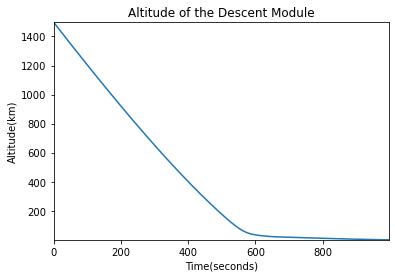

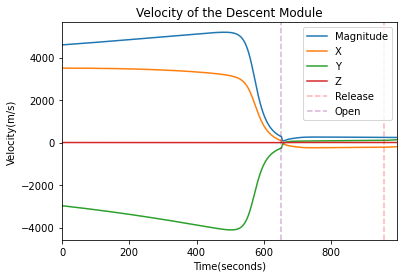

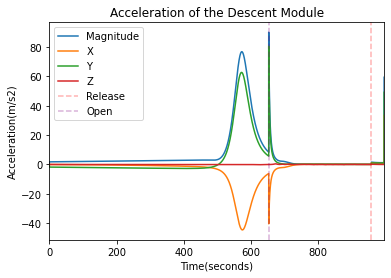

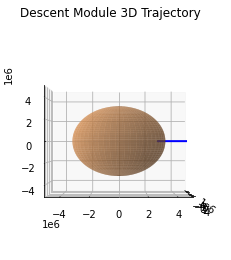

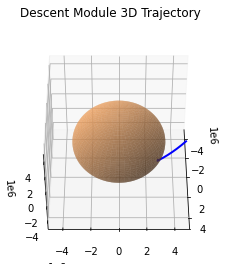

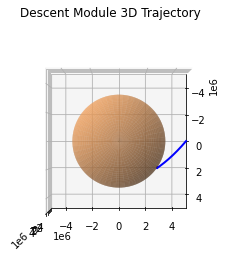

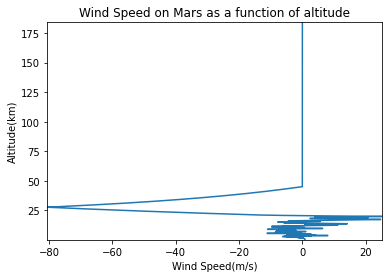

Open Time: 652.7399999995514
Release Time: 958.2399999992736
Contact Time: 996.0600099992391
Total Time: 996.0600199992391


The maximum acceleration experienced by the descent module was 89.96726535962966 m/s2
The airbag of the module impacted the ground at 1.3037608008126742 m/s
The rover was stopped by the airbag with a maximum pressure of 6999.908737933857 Pa


In [33]:
##### DRAG RUN-TYPE:

drag_acceleration_list, trial_time_list = max_drag = start_descent('drag', 0, 0, m_c, r_c, time_period)
drag_acceleration = max(drag_acceleration_list)
acceleration_cap = max([90, drag_acceleration])

##### PARACHUTE RUN-TYPE:

sample_alt_threshold = 5000 # placeholder data
largest_parachute_acceleration = 0 # placeholder data
parachute_acceleration_list, trial_time_list = start_descent('parachute', 0, sample_alt_threshold, m_c, r_c, time_period)

# Reverses lists; all the calculations below are done in reverse chronological order
parachute_acceleration_list.reverse()
trial_time_list.reverse()

# sets the acceleration to the max acceleration in the parachute descent or to 90 depending on which is smaller
acceleration_limit = min(max(parachute_acceleration_list), 90)
# finds the soonest opportunity after the initial decceleration to open the parachute
for i in range(len(parachute_acceleration_list)):
    if acceleration_limit == 90:
        # Find the first time period where releasing the parachute causes an excessive acceleration 
        if parachute_acceleration_list[i] > acceleration_limit:
            # select the time period beforehand as the optimum open time
            optimum_open_time = trial_time_list[i-1]   
            break
    else:
        # Checks if the acceleration is decreasing agian and if the acceleration is within 1 m/s2 of the limit
        if parachute_acceleration_list[i] < parachute_acceleration_list[i-1]:
            if parachute_acceleration_list[i] > acceleration_limit - 1:
                optimum_open_time = trial_time_list[i-1]

##### THRUSTERS RUN-TYPE:

optimum_release_altitude = start_descent('thrusters', optimum_open_time, sample_alt_threshold, m_c, r_c, time_period)

##### MAIN RUN-TYPE:
start_descent('main', optimum_open_time, optimum_release_altitude, m_c, r_c, time_period)

<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

# Hohmann Transfer from Earth to Mars

In order to improve the sophistication of our model, we decided to cover the transfer orbit between Earth and Mars. As such, we decided to use a Hohmann Transfer. The Hohmann Transfer tends to have the lowest impulses required to enter and exit from orbit, thus using the least propellant and being the most efficient.

Using this transger requires making some initial assumptions which are conditions of using the Hohmann Transfer, however they only marginally affect the accuracy of the model and are, for the most part, negligible:

1. The orbits of Mars and Earth are circular.

In reality they are mildly elliptical, with Earth's orbit eccentricity being 0.01671 and Mars' being 0.0935, but they are very nearly circular.

2. The orbits of Mars and Earth are centered on the sun.

Being mildly elliptical orbits, the Sun is not at the geometric centre of the orbits, but marginally offset. However, again, it is a largely insignificant difference.

3. The orbits of Mars and Earth occur in the same plane.

The planes of orbit of Mars and Earth are sligthly different, but close enough for the purposes of this model.

### Constants

In [34]:

'''CONSTANTS'''
r_earth_meters = 1.496*(10**11)
r_mars_meters = 2.2739*(10**11)
r_earth_au = 1
r_mars_au = 1.5264
m_sun =  1.989*(10**30)
G = 6.674*(10**-11)
period_mars = 1.88
period_earth = 1

The Semi Major Axis, $a$, of the transfer orbit is half the sum of Earth's orbital radius and Mars' orbital radius

$\displaystyle
a = \frac{r_e + r_m}{2} = \frac{1 + 1.5264}{2} = 1.263AU
$

In [35]:
transfer_semi_major_axis = (r_mars_au + r_earth_au)/2

The Perihelion is the point of an orbit closest to the sun. Since Earth's orbital radius is smaller than that of the sun, the Perihelion of the transfer orbit is simply the orbital radius of Earth. Using the equation below, we can calculate the eccentricity, $e$, of the transfer orbit.

$\displaystyle
\text{Perihelion} = a(1-e)$

$\displaystyle
e = 1 - \frac{r_e}{a} = 0.2084
$

In [36]:
eccentricity = 1 - r_earth_au/transfer_semi_major_axis

From the definition of eccentricity we get:

$\displaystyle
e = \sqrt{1-\frac{b^2}{a^2}}
$

We can rearrange to find the Semi Minor Axis, $b$, of the transfer:

$\displaystyle
b = a\sqrt{1-e^2} = \text{1.235}
$

In [37]:
transfer_semi_minor_axis = transfer_semi_major_axis * (1-(eccentricity)**2)**0.5

Kepler's Third Law states that:

$\displaystyle
\text{Period}^{2} = \text{Semi Major Axis}^{3}
$

This is true so long as the units for the period and Semi Major Axis are years and Astronomical Units respectively 

$\displaystyle
p = \sqrt{a^3} = 1.417 \, \text{years}
$

The time taken for the transfer however, is half the period.

$\displaystyle
T = \frac{p}{2} = 8.5 \, \text{months}
$

In [38]:
transfer_time = (transfer_semi_major_axis**(3/2))/2 # Kepler's Third Law

Since we make the assumption that the orbits of Mars and Earth are circular and centered on the sun, the velocity throughout their orbits is constant.

They are described by the equation:

$\displaystyle
V = \sqrt{\frac{GM_{sun}}{r}}
\\
$
Their respective orbital velocities therefore are:

$\displaystyle
V_e = \sqrt{\frac{GM_{sun}}{r_e}}
\\
V_m = \sqrt{\frac{GM_{sun}}{r_m}}
$

In [39]:
v_earth = (G*m_sun/r_earth_meters)**0.5
v_mars = (G*m_sun/r_mars_meters)**0.5

Now we must work out the impulses required to enter and exit the transfer orbit:

$\displaystyle
V_e + \Delta V_1 = V_P \\
V_a + \Delta V_2 = V_m
$

Where $V_a$ and $V_p$ are the velocities of the transfer orbit at the aphelion and perihelion respectively

The conservation of angular momentum means that:

$\displaystyle
L = m\cdot V_{p}\cdot r_{e} = m\cdot V_{a}\cdot r_{m}
$

From this we can immediately conclude that:

$\displaystyle
V_a = \frac{r_eV_p}{r_m}
$

The conservation of energy results in:

$\displaystyle
E = \frac{1}{2}m{v_p}^2 - \frac{GmM_{sun}}{r_e} = \frac{1}{2}m{v_a}^2 - \frac{GmM_{sun}}{r_m}
$

From there we can subsitute in for the velocity at the aphelion which resulted as a consequence of the conservation of angular momentum:

$\displaystyle
\frac{1}{2}m{v_p}^2 - \frac{GmM_{sun}}{r_e} = \frac{m}{2}\cdot\bigg(\frac{r_eV_p}{r}\bigg)^2 - \frac{GmM_{sun}}{r_m}
\\
{V_p}^2\big(1-\frac{r_e}{r_m}\big)^2 = 2GM_{sun}\big(\frac{1}{r_e} - \frac{1}{r_m}\big)
\\
{V_p} = \sqrt{2 G M_{sun} \big(\frac{r_m}{r_e(r_e+r_m)}\big)}
$

Therefore:

$
\Delta V_1 = \sqrt{\frac{GM_{sun}}{r_e}}\cdot \sqrt{\frac{2r_m}{r_e+r_m}-1} = \text{29788 ms}^{-1}
$

Through a similar process we can find the velocity required to leave the transfer orbit:

$\Delta V_2 = \sqrt{\frac{GM_{sun}}{r_e}}\cdot \sqrt{1-\frac{2r_m}{r_e+r_m}} = \text{24161 ms}^{-1}
$


In [40]:
delta_v1 = abs(((G * m_sun/r_earth_meters)**0.5)*(((2 * r_mars_au / (r_earth_meters  + r_mars_meters))**0.5) - 1))

delta_v2 = abs(((G * m_sun/r_mars_meters)**0.5)*(1-((2 * r_mars_au / (r_earth_meters  + r_mars_meters))**0.5)))

Now we calculate the start and end positions at Mars and Earth. The start position of Earth is at the perihelion and the end position of Mars is at the aphelion in order for the Hohmann Transfer to be successful.

In [41]:
mars_angle  = np.pi - 2*(np.pi)*(transfer_time/period_mars)

earth_angle = 2*(np.pi)*(transfer_time/period_earth)


x_earth_initial = r_earth_au * np.cos(0)
y_earth_initial = r_earth_au * np.sin(0)
x_earth_final = r_earth_au * np.cos(earth_angle)
y_earth_final = r_earth_au *np.sin(earth_angle)

x_mars_initial = r_mars_au * np.cos(mars_angle)
y_mars_initial = y = r_mars_au * np.sin(mars_angle) 
x_mars_final = r_mars_au * np.cos(np.pi)
y_mars_final = y = r_mars_au * np.sin(np.pi) 

Finally, we plot the motions of the various orbits and return calculated values, including a label for the initial starting point of Mars, as that restricts when the launch must occur.


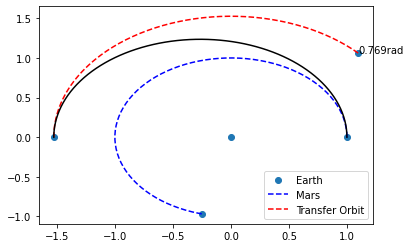

Entry Impulse: 29788.1 m/s
Exit Impulse: 24161.5 m/s
Transit Time: 0.71 years
Initial Mars Angle: 0.769 radians


In [42]:
x_coords = [0, x_earth_initial, x_mars_initial, x_mars_final, x_earth_final]
y_coords = [0, y_earth_initial, y_mars_initial, y_mars_final, y_earth_final]

e_angle = np.linspace( 0 , earth_angle , 150 ) 
m_angle = np.linspace( mars_angle, np.pi, 150) 
transfer_angle = np.linspace(0, np.pi, 150)

x_orbit_earth = r_earth_au * np.cos( e_angle ) 
y_orbit_earth = r_earth_au * np.sin( e_angle ) 

x_orbit_mars = r_mars_au * np.cos(m_angle)
y_orbit_mars = r_mars_au * np.sin(m_angle) 

#plot hohmann transfer - x orbit is adjusted to be centred
x_orbit_transfer = transfer_semi_major_axis * np.cos(transfer_angle) - transfer_semi_major_axis + r_earth_au
y_orbit_transfer = transfer_semi_minor_axis * np.sin(transfer_angle)
 
 
figure, axes = plt.subplots( 1 ) 
 
axes.scatter(x_coords, y_coords)
axes.plot( x_orbit_earth, y_orbit_earth, 'blue', linestyle = 'dashed') 
axes.plot(x_orbit_mars, y_orbit_mars,'red', linestyle = 'dashed')
axes.plot(x_orbit_transfer, y_orbit_transfer, 'black')
axes.legend(['Earth','Mars', 'Transfer Orbit'])
axes.annotate((f"{mars_angle:.3}")+'rad',(x_mars_initial, y_mars_initial))
plt.show()


print('Entry Impulse: ' + f"{delta_v1:.6}"+ ' m/s')
print('Exit Impulse: ' + f"{delta_v2:.6}" + ' m/s')
print('Transit Time: ' + f"{transfer_time:.3}" + ' years')
print('Initial Mars Angle: ' + f"{mars_angle:.3}" + ' radians')